# Retail Data Wrangling and Analytics with PySpark

In [0]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#Create SparkSession for using Spark Structured APIs
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession \
.builder \
.appName("DataBricks Spark SQL basic example") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

## Import Dataset as Pandas Dataframe

In [0]:
import pandas as pd

df = pd.read_csv("/dbfs/FileStore/shared_uploads/macton@uwo.ca/online_retail_II.csv")
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.strftime('%Y%m')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,200912,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,200912,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,200912,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,200912,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,200912,1.25,13085.0,United Kingdom


# Total Invoice Amount Distribution

In [0]:
#Calculate gross price of each item
df["Total_Price"] = df["Quantity"]*df["Price"]
#Calculate total value of each invoice
invoice_total = df.groupby("Invoice", as_index=False)["Total_Price"].sum()
invoice_total.head()


,Invoice,Total_Price
0,489434,505.30
1,489435,145.80
2,489436,630.33
3,489437,310.75
4,489438,2286.24


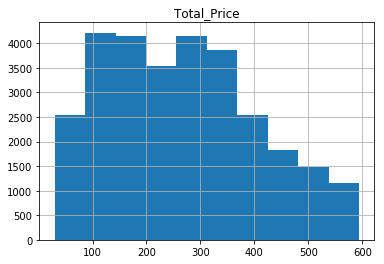

In [0]:
#Remove outliers
invoice_total_filtered = invoice_total[invoice_total["Total_Price"].between(invoice_total["Total_Price"].quantile(.3), invoice_total["Total_Price"].quantile(.85))]
#Plot histogram

invoice_total_filtered.hist()


In [0]:
#Statistical Values
print("Min: " + str(invoice_total_filtered["Total_Price"].min()))
print("Max: " + str(invoice_total_filtered["Total_Price"].max()))
print("Mean: " + str(invoice_total_filtered["Total_Price"].mean()))
print("Median: " + str(invoice_total_filtered["Total_Price"].median()))
print("Mode: " + str(invoice_total_filtered["Total_Price"].mode()))

Min: 29.849999999999998
Max: 594.0
Mean: 267.7430639452092
Median: 261.375
Mode: 0 30.0
dtype: float64

# Monthly Placed and Canceled Orders

In [0]:
is_cancelled = df["Invoice"].str.startswith("C")
cancelled_orders = df[is_cancelled]
cancelled_orders.head()
cancelled_orders_monthly= cancelled_orders.groupby(['InvoiceDate']).size()
cancelled_orders_df = pd.DataFrame({'Month':cancelled_orders_monthly.index, 'Cancelled':cancelled_orders_monthly.values})
cancelled_orders_df.head()


,Month,Cancelled
0,2009-12-01,1015
1,2010-01-01,686
2,2010-02-01,576
3,2010-03-01,844
4,2010-04-01,626


In [0]:
# Get Placed Orders
monthly_placed_orders = df.groupby(['InvoiceDate']).size()
monthly_placed_orders = pd.DataFrame({'Month':monthly_placed_orders.index, 'Placed':monthly_placed_orders.values})
monthly_placed_orders.head()

,Month,Placed
0,200912,45228
1,201001,31555
2,201002,29388
3,201003,41511
4,201004,34057


# Monthly Sales

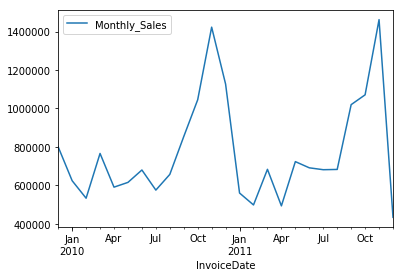

In [0]:
df["Monthly_Sales"] = df["Quantity"]*df["Price"]
monthly_sales = df.groupby("InvoiceDate", as_index=False)["Monthly_Sales"].sum()
monthly_sales.plot.line(x="InvoiceDate", y="Monthly_Sales")

# Monthly Sales Growth

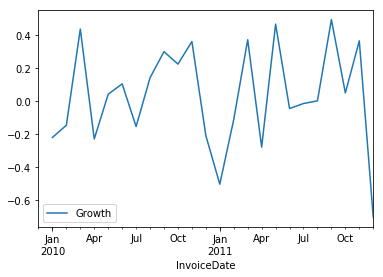

In [0]:
#Sales Growth
monthly_sales["Growth"] = monthly_sales["Monthly_Sales"].pct_change()
monthly_sales.plot.line(x="InvoiceDate", y="Growth")

# Monthly Active Users

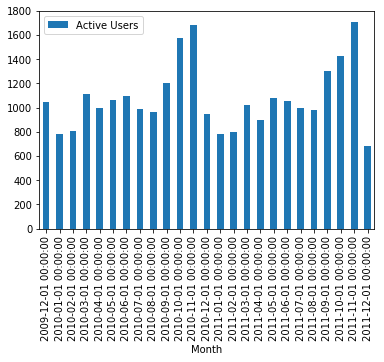

In [0]:
#Active Users
active_users=df.groupby('InvoiceDate')['Customer ID'].nunique()
active_users = pd.DataFrame({'Month':active_users.index, 'Active Users':active_users.values})
active_users.plot.bar(x="Month", y="Active Users")

# New and Existing Users

In [0]:
#Determine each customer's first purchase date
join_month = df.groupby("Customer ID")["InvoiceDate"].min()
join_month = pd.DataFrame({'Customer ID':join_month.index, 'Join Month':join_month.values})
join_month.head()

,Customer ID,Join Month
0,12346.0,200912
1,12347.0,201010
2,12348.0,201009
3,12349.0,200912
4,12350.0,201102


In [0]:
#Calculate new users for each month
df_join_month = df.merge(join_month,how='left', left_on='Customer ID', right_on='Customer ID')
df_join_month.head()
new_users=df_join_month[df_join_month["Join Month"] == df_join_month["InvoiceDate"]]
new_users = new_users.groupby(["Join Month"]).count()
new_users = new_users["Customer ID"]
new_users = pd.DataFrame({'Month':new_users.index, 'New Users':new_users.values})
new_users.head()


,Month,New Users
0,200912,31760
1,201001,9625
2,201002,9689
3,201003,12344
4,201004,6779


In [0]:
#Find monthly existing users
existing_users=df_join_month[df_join_month["Join Month"] < df_join_month["InvoiceDate"]]
existing_users = existing_users.groupby(["InvoiceDate"]).count()
existing_users = existing_users["Customer ID"]
existing_users = pd.DataFrame({'Month':existing_users.index, 'Existing Users':existing_users.values})
existing_users.head()

,Month,Existing Users
0,201001,12814
1,201002,14217
2,201003,20770
3,201004,21054
4,201005,23121


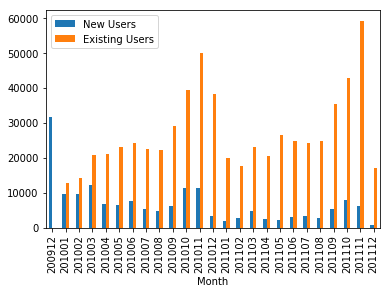

In [0]:
#Plot
new_and_existing = new_users.merge(existing_users,how='left', left_on='Month', right_on='Month')
new_and_existing.plot.bar(x='Month')

## Finding RFM
### R: Recency - How many days since last purchase?
### F: Frequency - How many purchases in the past year?
### M: Monetary - Total value spent by each customer

In [0]:
#Monetary - Total value of purchases made by customer
df_m = df[["Customer ID", "Quantity", "Price"]]
df_m["Total Price"] = df_m["Quantity"]*df_m["Price"]
df_m = df_m.groupby("Customer ID").sum()
df_m = df_m["Total Price"]
df_m = pd.DataFrame({'Customer ID':df_m.index, 'Monetary':df_m.values})

/local_disk0/tmp/1640184791737-0/PythonShell.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

In [0]:
#Frequency - Number of purchases in last 12 months
df_f = df[df["InvoiceDate"] > "201012"]	
df_f = df_f[["Customer ID", "Invoice"]]
df_f = df_f.groupby("Customer ID").count()
df_f = df_f["Invoice"]
df_f = pd.DataFrame({'Customer ID':df_f.index, 'Frequency':df_f.values})

In [0]:
current_month = pd.to_datetime("2012/01")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],format='%Y%m', errors='coerce').dropna()
df_r = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (current_month - x.max()).days}) #recency value
df_r = df_r["InvoiceDate"]
df_r = pd.DataFrame({'Customer ID':df_r.index, 'Recency':df_r.values})

In [0]:
#Join RFM Tables
rfm_table = pd.merge(pd.merge(df_r,df_f,on='Customer ID'),df_m,on='Customer ID')

In [0]:
#Assign RFM Scores
rfm_table['RecencyScore'] = pd.qcut(rfm_table['Recency'].rank(method="first"),5,labels=[5,4,3,2,1])
rfm_table['FrequencyScore'] = pd.qcut(rfm_table['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_table['MonetaryScore'] = pd.qcut(rfm_table['Monetary'],5,labels=[1,2,3,4,5])
rfm_table["RFM_SCORE"] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)
rfm_table.head()

,Customer ID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
0,12346.0,365,2,-64.68,1,1,1,111
1,12347.0,31,151,5633.32,5,5,5,555
2,12348.0,122,14,2019.40,2,1,4,214
3,12349.0,61,73,4404.54,5,4,5,545
4,12350.0,334,17,334.40,1,2,1,121


# RFM Segmentation

In [0]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)

In [0]:
rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

Recency 
 Frequency 
 Monetary 
 
 
 
 mean 
 count 
 mean 
 count 
 mean 
 count 
 
 
 Segment 
 
 
 
 
 
 
 
 
 
 
 About to Sleep 
 85.017065 
 293 
 15.075085 
 293 
 877.787270 
 293 
 
 
 At Risk 
 185.541880 
 585 
 54.941880 
 585 
 2059.363545 
 585 
 
 
 Can't Lose 
 163.253165 
 79 
 175.417722 
 79 
 4799.699380 
 79 
 
 
 Champions 
 35.905336 
 581 
 269.771084 
 581 
 12618.372401 
 581 
 
 
 Hibernating 
 228.464217 
 1034 
 13.369439 
 1034 
 1094.277091 
 1034 
 
 
 Loyal Customers 
 69.588092 
 823 
 161.851762 
 823 
 4963.780258 
 823 
 
 
 Need Attention 
 82.558376 
 197 
 40.969543 
 197 
 1501.275381 
 197 
 
 
 New Customers 
 39.644068 
 59 
 7.661017 
 59 
 1218.526949 
 59 
 
 
 Potential Loyalists 
 51.462777 
 497 
 33.426559 
 497 
 1551.227225 
 497 
 
 
 Promising 
 61.000000 
 96 
 6.906250 
 96 
 810.684479 
 96